<a href="https://colab.research.google.com/github/entc-17-fyp-20/CM_Normal_Behaviour_Modeling/blob/akeshala/CNN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Target Variable🎯 - Generator_Bearing_Tempeature**

In [ ]:
#@title Select Dataset New { display-mode: "form" }

# This note book is for Canada dataset
turbine = 'T01' #@param ["T01","T02","T03","T09","T22","T34","T40","T54"]
split1 = 0.4 #@param {type:"slider", min:0.1, max:0.9, step:0.05}
split2 = 0.6 #@param {type:"slider", min:0.1, max:0.9, step:0.05}

In [ ]:
# Run this cell to connect to gdrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import libraries and datasets

In [ ]:
# multivariate data preparation
from numpy import array
from numpy import hstack
import pandas as pd
import numpy as np
from sklearn import preprocessing
from datetime import datetime
import os
from math import sqrt

from keras.models import Sequential, load_model
from keras.metrics import mean_squared_error
from keras.layers import Flatten, BatchNormalization, Dropout, LocallyConnected2D, LeakyReLU, ReLU, Dense
from keras.layers.convolutional import Conv2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [ ]:
# Import statistics of normal behaviour
features = ['Active_Power','Ambient_Temperature','Wind_Speed','Generator_RPM','Generator_Bearing_Tempeature']  # features list
path = '/content/drive/MyDrive/IIoT - Wind Turbine/FYP/Dataset/T1-T3_stats.csv'
statistics = pd.read_csv(path)
statistics = statistics.set_index(statistics['Unnamed: 0'])
statistics.drop('Unnamed: 0', inplace=True, axis=1)

In [ ]:
#@title Helper Functions { display-mode: "form" }

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
def maxmin(x, ftr):
	stat = statistics.loc[ftr,:]
	x = (x-stat['min'])/(stat['max']-stat['min'])	 
	return x


def datetime_to_string(x):
	return x.strftime("%Y-%m-%d %H:%M:%S")

def apply_iforest(df):
  column_names = list(df.columns)
  df_new = pd.DataFrame()
  from pycaret.anomaly import setup, create_model, assign_model
  for column_name in column_names:
    df_sub = pd.DataFrame()
    df_sub = df[[column_name]]
    df_sub['MA48'] = df_sub[column_name].rolling(16,center=True,min_periods=1).mean()
    s = setup(df_sub, session_id = 123, silent=True, verbose=False)
    iforest = create_model('iforest', fraction = 0.1)
    iforest_results = assign_model(iforest)
    df_new[column_name] = iforest_results['MA48'].values*iforest_results['Anomaly'].values+iforest_results[column_name].values*(1-iforest_results['Anomaly'].values)

  return df_new
 
n_steps = 144 # 10 min data points of a day=24*6

In [ ]:
#turbine = 'T01' #@param ["T01", "T02","T03","T22","T34","T54"]
# turbine2 = 'T02' #@param ["T01", "T02","T03","T22","T34","T54"]
path = '/content/drive/MyDrive/IIoT - Wind Turbine/FYP/Dataset/Merged/' + turbine + '.csv'
dfy = pd.read_csv(path)

# This code is used to combine two datasets for coding. 
# path = '/content/drive/MyDrive/IIoT - Wind Turbine/FYP/Dataset/Merged/' + turbine2 + '.csv'
# dfy2 = pd.read_csv(path)
# dfy2['Date_Time'] = pd.to_datetime(dfy2['Date_Time'])
# dfy2['Date_Time'] = dfy2['Date_Time'] + pd.DateOffset(days=730)
# dfy2['Date_Time'] = dfy2['Date_Time'].apply(datetime_to_string)

# df = pd.concat([dfy, dfy2], ignore_index=True)

df = dfy[['Date_Time', 'Ambient_Temperature', 'Wind_Speed', 'Generator_RPM', 'Active_Power', 'Generator_Bearing_Tempeature']]

In [ ]:
#@title Select scaling method { display-mode: "form" }
method = 'MinMax' #@param ["Normalize", "MinMax"]

df_time = df["Date_Time"]
df.drop("Date_Time", axis='columns', inplace=True)
column_names = df.columns

if method == "Normalize":
  d = preprocessing.normalize(df, axis=0)
  df = pd.DataFrame(d, columns=column_names)
else:
  for ftr in features:
    df[ftr] = df[ftr].apply(lambda row : maxmin(row, ftr))

df["Date_Time"] = df_time
df = df.set_index(df['Date_Time'])

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

In [ ]:
#handling large data losses
n_features = 4
format = '%Y-%m-%d %H:%M:%S'
split_index=[];
split_index.append(df['Date_Time'][0])
for i in range(0,len(df['Date_Time'])-1):
  current_time =  df['Date_Time'][i]
  following_time=  df['Date_Time'][i+1]
  time_gap =datetime.strptime(following_time, format)-datetime.strptime(current_time, format)
  if (time_gap.total_seconds() != 600):
    split_index.append(current_time)
    split_index.append(following_time)
split_index.append(df['Date_Time'][len(df['Date_Time'])-1])

df = df.set_index(df['Date_Time'])

In [ ]:
X_concat_train, y_concat_train, y_concat_test, X_concat_test = [],[],[],[]

for i in range(0,len(split_index),2):
  dfx = df[split_index[i]:split_index[i+1]]
  if len(dfx)>=144:
    dfx = dfx[features]
    # dfx = apply_iforest(dfx)
    dfx = dfx.to_numpy()
    # convert into input/output
    X, y = split_sequences(dfx, n_steps)
    if i<len(split_index)*split1 or  i>len(split_index)*split2:
      X_concat_train.append(X)
      y_concat_train.append(y)
    else: #if i<=len(split_index)*0.5:
      X_concat_test.append(X)
      y_concat_test.append(y)

X_concat_train = tuple(X_concat_train)
y_concat_train = tuple(y_concat_train)

X_concat_test = tuple(X_concat_test)
y_concat_test = tuple(y_concat_test)

In [ ]:
X_train = np.concatenate(X_concat_train)
y_train = np.concatenate(y_concat_train)

X_test = np.concatenate(X_concat_test)
y_test = np.concatenate(y_concat_test)

In [ ]:
print("Train "+str(len(X_train)))
print("Test "+str(len(X_test)))
print(X_train.shape)
print(y_train.shape)

Train 55379
Test 13879
(55379, 144, 4)
(55379,)


In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],X_train.shape[2],1))
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],X_test.shape[2],1))

# Model

In [ ]:
def create_model():
  # define model
  model1 = Sequential()
  model1.add(Conv2D(filters=128, kernel_size=(32,4), input_shape=(n_steps, n_features,1), padding="same"))
  model1.add(BatchNormalization())
  model1.add(ReLU())
  model1.add(Dropout(0.1))
  model1.add(Conv2D(filters=128, kernel_size=(18,4), padding="same"))
  model1.add(BatchNormalization())
  model1.add(ReLU())
  model1.add(Dropout(0.1))
  model1.add(Conv2D(filters=128, kernel_size=(8,4), padding="same"))
  model1.add(BatchNormalization())
  model1.add(ReLU())
  model1.add(Dropout(0.1))
  model1.add(Conv2D(filters=128, kernel_size=(8,4), padding="same"))
  model1.add(BatchNormalization())
  model1.add(ReLU())
  model1.add(Dropout(0.1))
  model1.add(LocallyConnected2D(filters=10, kernel_size=(8, 4), activation="relu"))
  model1.add(Flatten())
  model1.add(Dense(20, activation='relu'))
  model1.add(BatchNormalization())
  model1.add(Dense(1))
  model1.add(LeakyReLU(alpha=0.1))
  model1.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae', 'mape'])
  return model1

# Training 

In [ ]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)
best_val = ModelCheckpoint('model_{epoch:02d}.h5', save_best_only=True, mode='min')

logdir = os.path.join("logs", datetime.now().strftime("%Y%m%d-%H%M%S"))
# tensorboard_callback = TensorBoard(log_dir=logdir, histogram_freq=1)

In [ ]:
n_features = X_train.shape[2]

model = create_model()
# model.summary()

In [ ]:
# fit model
history = model.fit(X_train, y_train, batch_size=5, validation_data=(X_test,y_test), callbacks=[best_val], epochs=15, verbose=1) # callbacks=[best_val, earlystop, ,tensorboard_callback]

Epoch 1/15
11076/11076 [==============================] - 294s 25ms/step - loss: 0.0126 - mse: 0.0126 - mae: 0.0847 - mape: 26.5180 - val_loss: 0.0266 - val_mse: 0.0266 - val_mae: 0.1534 - val_mape: 29.6921
Epoch 2/15
11076/11076 [==============================] - 280s 25ms/step - loss: 0.0086 - mse: 0.0086 - mae: 0.0740 - mape: 22.4470 - val_loss: 0.0052 - val_mse: 0.0052 - val_mae: 0.0612 - val_mape: 11.8310
Epoch 3/15
11076/11076 [==============================] - 279s 25ms/step - loss: 0.0081 - mse: 0.0081 - mae: 0.0716 - mape: 21.2421 - val_loss: 0.0018 - val_mse: 0.0018 - val_mae: 0.0347 - val_mape: 7.5077
Epoch 4/15
11076/11076 [==============================] - 281s 25ms/step - loss: 0.0079 - mse: 0.0079 - mae: 0.0710 - mape: 20.8912 - val_loss: 0.0014 - val_mse: 0.0014 - val_mae: 0.0295 - val_mape: 5.8695
Epoch 5/15
11076/11076 [==============================] - 279s 25ms/step - loss: 0.0076 - mse: 0.0076 - mae: 0.0700 - mape: 20.5539 - val_loss: 0.0020 - val_mse: 0.0020 - val

In [ ]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model.load_weights("model_{:02d}.h5".format(best_epoch))

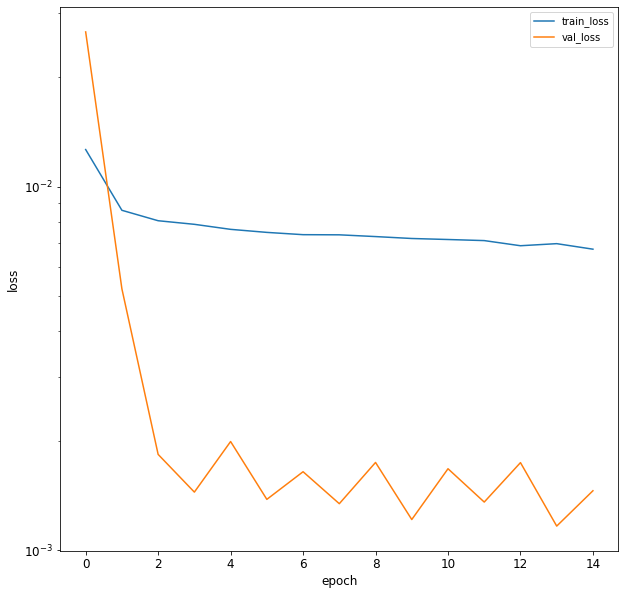

In [ ]:
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(10,10), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

In [ ]:
# Save the weights
path = '/content/drive/MyDrive/Machine Learning Models/FYP/CNN2.6/model.h5'
model.save(path)

In [ ]:
# %tensorboard --logdir logs

# Import pre-trained weights

Check model number

In [ ]:
path = '/content/drive/MyDrive/Machine Learning Models/FYP/CNN2.6/model.h5'

# Load the model
model = load_model(path)

# Validation on the same turbine

In [ ]:
# demonstrate prediction
yhat = model.predict(X_test, verbose=1)

434/434 [==============================] - 11s 22ms/step


In [ ]:
yhat = yhat.reshape(yhat.shape[0],)
df_final=pd.DataFrame({'y_hat':yhat,'y_test':y_test})

In [ ]:
df_final['difference'] = df_final['y_hat']-df_final['y_test']
df_final["abs_difference"] = abs(df_final['y_hat']-df_final['y_test'])

In [ ]:
# df_final.to_csv('drive/MyDrive/DatasetsWind/df_final.csv', index=False)

# Results, Plots

In [ ]:
print(df_final["difference"].mean())
print(df_final["abs_difference"].mean())
print("Mean squared error " + str(np.sqrt(mean_squared_error(df_final['y_test'].values, df_final['y_hat'].values))))

0.00030374205917490995
0.026117602450996293
Mean squared error 0.034134306


In [ ]:
# Adding data_time column back
frames = []

for i in range(0,len(split_index),2):
  dfx = df[split_index[i]:split_index[i+1]]

  if i>=len(split_index)*split1 or i<=len(split_index)*split2:
    frames.append(dfx.iloc[n_steps-1:,:])

test = pd.concat(frames)
test.drop("Date_Time", axis='columns', inplace=True)
test = test.reset_index()
df_final["Date_Time"] = test["Date_Time"]

In [ ]:
column_name = 'y_test' 
column_name1 = 'y_hat'

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_final['Date_Time'], y=df_final[column_name], mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=df_final['Date_Time'],y=df_final[column_name1], mode='lines', name='Predicted'))
fig.update_layout(title_text= "Actual vs Predicted")

fig.show()

In [ ]:
column_name = 'difference' 

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_final['Date_Time'], y=df_final[column_name], mode='lines', name='Error'))
fig.update_layout(title_text= "Error")

fig.show()

In [ ]:
column_name = 'abs_difference' 

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_final['Date_Time'], y=df_final[column_name], mode='lines', name='Absolute Error'))
fig.update_layout(title_text= "Absolute Error")

fig.show()

Re-sampling data

In [ ]:
#@title Resampling { display-mode: "form" }
sample_frequency = 60 #@param {type:"slider", min:20, max:120, step:10}
sample = str(sample_frequency) + "min"

In [ ]:
df_final['Date_Time'] = pd.to_datetime(df_final['Date_Time'], format="%Y-%m-%d %H:%M:%S")
df_final.set_index('Date_Time', inplace = True)
df_resample = df_final.resample(sample).mean().reset_index()
df_final = df_final.reset_index()

In [ ]:
column_name = 'difference' 

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_resample['Date_Time'], y=df_resample[column_name], mode='lines', name='Error'))
fig.update_layout(title_text= "Error")

fig.show()

In [ ]:
column_name = 'abs_difference' 

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_resample['Date_Time'], y=df_resample[column_name], mode='lines', name='Absolute Error'))
fig.update_layout(title_text= "Absolute Error")

fig.show()